# Vision Transformer (ViT) 训练 - CIFAR-10

本 Notebook 实现了 ViT 在 CIFAR-10 数据集上的完整训练流程。

## 训练配置
- 数据集：CIFAR-10 (32x32 彩色图像，10分类)
- 模型：Vision Transformer
- 训练轮数：5 epochs
- 批次大小：64

## 1. 导入依赖库

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

from vit import VisionTransformer

print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 设备: {torch.cuda.get_device_name(0)}")

PyTorch 版本: 2.9.1+cu130
CUDA 可用: True
CUDA 设备: NVIDIA GeForce RTX 5070 Ti Laptop GPU


## 2. 超参数配置

In [26]:
# ==================== 超参数配置 ====================
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.05
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 模型参数（适配CIFAR-10）
IMG_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 10
EMBED_DIM = 256
DEPTH = 6
NUM_HEADS = 8

# 数据加载参数
NUM_WORKERS = 2
PRINT_FREQ = 100

print("=" * 50)
print("训练配置")
print("=" * 50)
print(f"设备: {DEVICE}")
print(f"批次大小: {BATCH_SIZE}")
print(f"学习率: {LEARNING_RATE}")
print(f"训练轮数: {EPOCHS}")
print(f"模型配置: Embed={EMBED_DIM}, Depth={DEPTH}, Heads={NUM_HEADS}")
print("=" * 50)

训练配置
设备: cuda
批次大小: 32
学习率: 0.0001
训练轮数: 10
模型配置: Embed=256, Depth=6, Heads=8


## 3. 数据加载与预处理

In [27]:
# 训练集数据增强
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 测试集预处理
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载数据集
print("正在加载 CIFAR-10 数据集...")
train_dataset = datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform_train
)

test_dataset = datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform_test
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print(f"✅ 数据加载完成")
print(f"训练集: {len(train_dataset)} 样本, {len(train_loader)} 批次")
print(f"测试集: {len(test_dataset)} 样本, {len(test_loader)} 批次")

# CIFAR-10 类别名称
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

正在加载 CIFAR-10 数据集...
✅ 数据加载完成
训练集: 50000 样本, 1563 批次
测试集: 10000 样本, 313 批次
✅ 数据加载完成
训练集: 50000 样本, 1563 批次
测试集: 10000 样本, 313 批次


## 4. 可视化样本数据

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..0.9816474].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.6622524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.257557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.769559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.4468853].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71

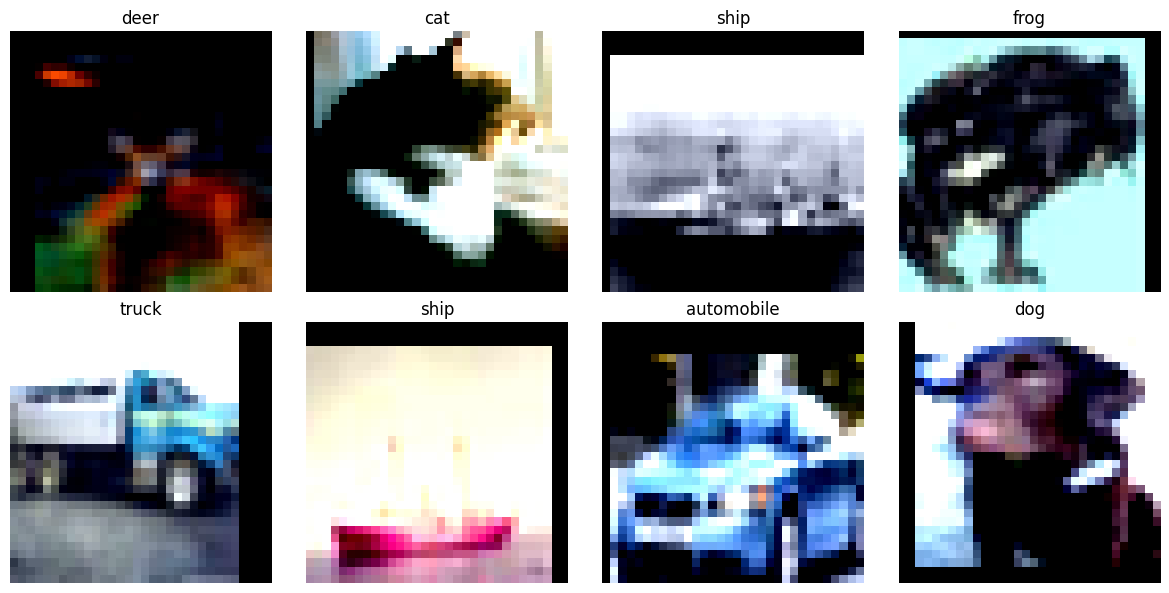

样本形状: torch.Size([32, 3, 32, 32])
标签形状: torch.Size([32])


In [28]:
# 显示一些训练样本
def imshow(img, title=None):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# 获取一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 显示前8张图片
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    if idx < 8:
        ax.imshow(np.transpose(images[idx].numpy() / 2 + 0.5, (1, 2, 0)))
        ax.set_title(classes[labels[idx]])
        ax.axis('off')
plt.tight_layout()
plt.show()

print(f"样本形状: {images.shape}")
print(f"标签形状: {labels.shape}")

## 5. 初始化模型

In [29]:
# 创建模型
model = VisionTransformer(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    in_chans=3,
    embed_dim=EMBED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    num_classes=NUM_CLASSES,
).to(DEVICE)

# 统计参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 50)
print("模型信息")
print("=" * 50)
print(f"总参数量: {total_params:,}")
print(f"可训练参数量: {trainable_params:,}")
print(f"模型大小: {total_params * 4 / 1024 / 1024:.2f} MB (FP32)")
print("=" * 50)

# 测试前向传播
with torch.no_grad():
    test_input = torch.randn(2, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    test_output = model(test_input)
    print(f"\n✅ 模型前向传播测试通过")
    print(f"输入形状: {test_input.shape}")
    print(f"输出形状: {test_output.shape}")

模型信息
总参数量: 4,771,082
可训练参数量: 4,771,082
模型大小: 18.20 MB (FP32)

✅ 模型前向传播测试通过
输入形状: torch.Size([2, 3, 32, 32])
输出形状: torch.Size([2, 10])


## 6. 设置训练组件

In [30]:
# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)

# 学习率调度器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=EPOCHS
)

print("✅ 训练组件初始化完成")
print(f"优化器: AdamW")
print(f"学习率调度: CosineAnnealing")
print(f"损失函数: CrossEntropyLoss")

✅ 训练组件初始化完成
优化器: AdamW
学习率调度: CosineAnnealing
损失函数: CrossEntropyLoss


## 7. 定义训练和测试函数

In [31]:
def train_one_epoch(epoch, history):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 统计
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # 打印进度
        if (batch_idx + 1) % PRINT_FREQ == 0:
            avg_loss = running_loss / (batch_idx + 1)
            acc = 100. * correct / total
            print(f'  [{epoch+1}/{EPOCHS}] [{batch_idx+1}/{len(train_loader)}] '
                  f'Loss: {avg_loss:.4f} Acc: {acc:.2f}%')
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, epoch_time


def test(epoch):
    """测试模型"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc


def plot_history(history):
    """绘制训练历史"""
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss曲线
    ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    ax1.plot(epochs_range, history['test_loss'], 'r-s', label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy曲线
    ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    ax2.plot(epochs_range, history['test_acc'], 'r-s', label='Test Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ 训练函数定义完成")

✅ 训练函数定义完成


## 8. 开始训练

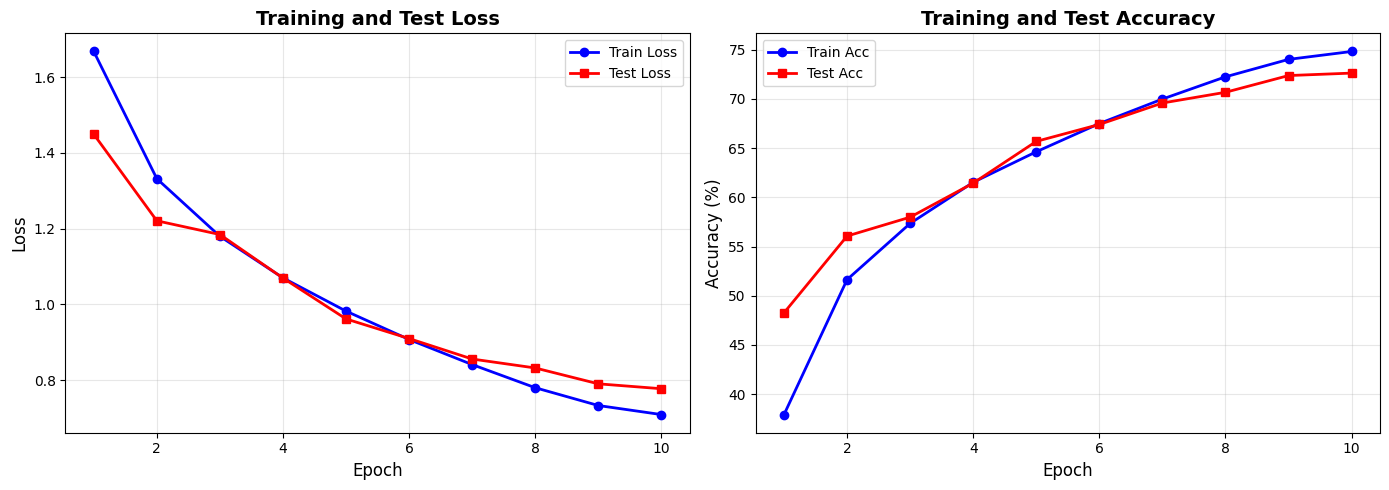


训练完成！
最佳测试准确率: 72.63%


In [32]:
print("=" * 50)
print("开始训练")
print("=" * 50)

best_acc = 0.0
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
    'lr': []
}

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*50}")
    
    # 训练
    train_loss, train_acc, epoch_time = train_one_epoch(epoch, history)
    
    # 测试
    test_loss, test_acc = test(epoch)
    
    # 更新学习率
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)
    
    # 打印总结
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{EPOCHS} 完成 (用时: {epoch_time:.1f}s)")
    print(f"学习率: {current_lr:.6f}")
    print(f"训练 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"测试 - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")
    
    # 保存最佳模型
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
            'history': history,
        }, 'output/best_model.pth')
        print(f"✅ 保存最佳模型 (准确率: {test_acc:.2f}%)")
    
    print(f"{'='*50}")
    
    # 实时绘制训练曲线
    if epoch > 0:  # 至少有2个点才绘制
        clear_output(wait=True)
        plot_history(history)

print("\n" + "="*50)
print("训练完成！")
print(f"最佳测试准确率: {best_acc:.2f}%")
print("="*50)

## 9. 可视化训练结果

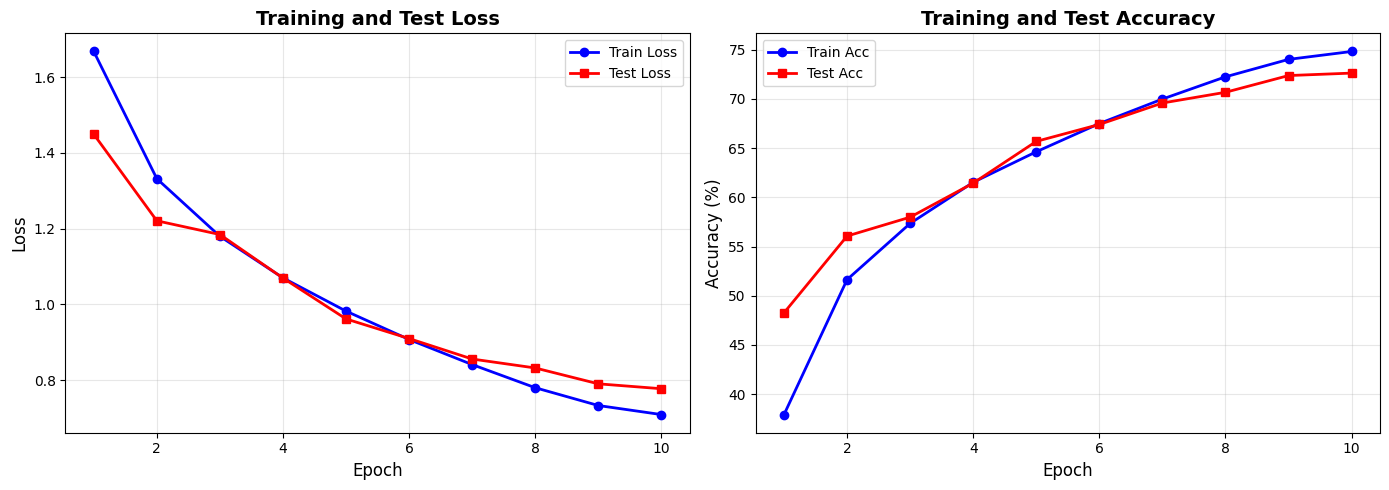


训练历史详情:
Epoch   Train Loss  Train Acc   Test Loss   Test Acc    LR          
----------------------------------------------------------------------
1       1.6680      37.93       1.4494      48.27       0.000098    
2       1.3320      51.65       1.2209      56.07       0.000090    
3       1.1799      57.35       1.1846      57.99       0.000079    
4       1.0701      61.53       1.0696      61.45       0.000065    
5       0.9823      64.64       0.9617      65.69       0.000050    
6       0.9073      67.50       0.9098      67.41       0.000035    
7       0.8411      69.99       0.8558      69.59       0.000021    
8       0.7800      72.25       0.8321      70.68       0.000010    
9       0.7330      74.02       0.7903      72.38       0.000002    
10      0.7091      74.83       0.7773      72.63       0.000000    


In [33]:
# 绘制最终训练曲线
plot_history(history)

# 打印训练历史表格
print("\n训练历史详情:")
print(f"{'Epoch':<8}{'Train Loss':<12}{'Train Acc':<12}{'Test Loss':<12}{'Test Acc':<12}{'LR':<12}")
print("-" * 70)
for i in range(len(history['train_loss'])):
    print(f"{i+1:<8}{history['train_loss'][i]:<12.4f}{history['train_acc'][i]:<12.2f}"
          f"{history['test_loss'][i]:<12.4f}{history['test_acc'][i]:<12.2f}{history['lr'][i]:<12.6f}")

## 10. 测试模型预测

✅ 加载最佳模型 (Epoch 10, 准确率: 72.63%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

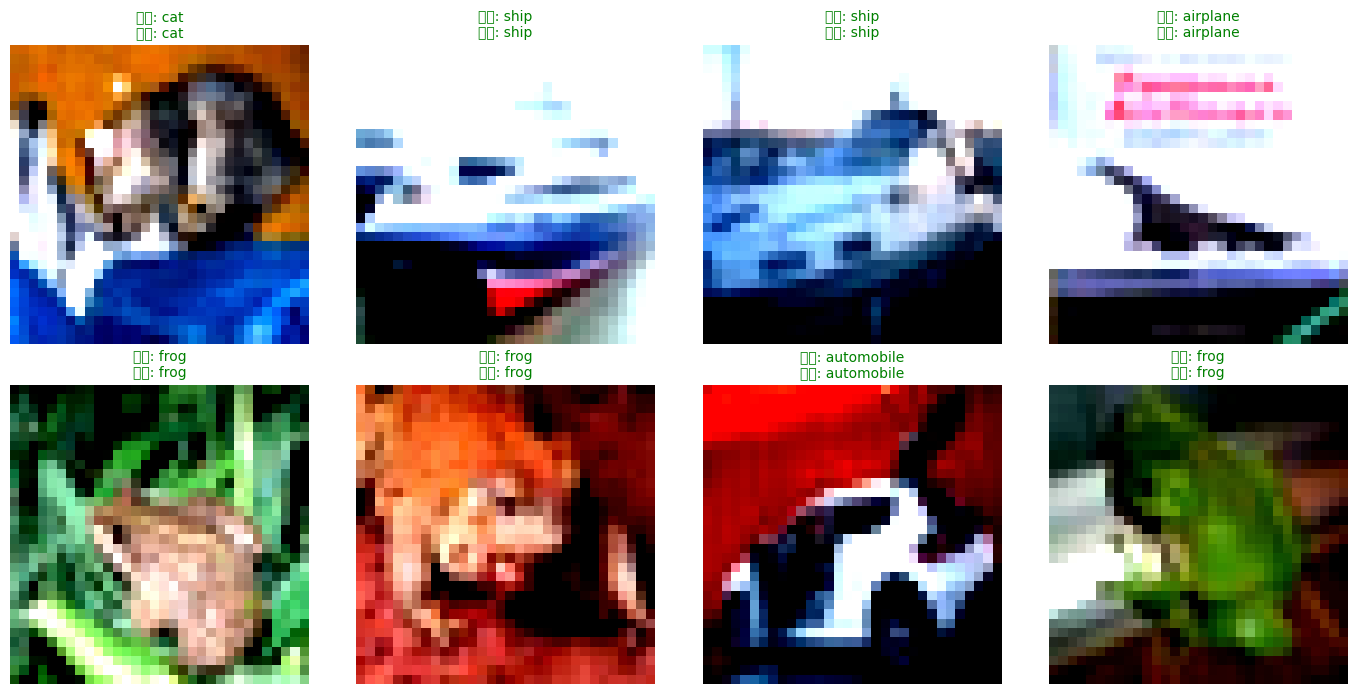


这批样本的准确率: 93.75% (30/32)


In [34]:
# 加载最佳模型
checkpoint = torch.load('output/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ 加载最佳模型 (Epoch {checkpoint['epoch']}, 准确率: {checkpoint['test_acc']:.2f}%)")

# 获取测试样本
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)

# 预测
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# 可视化预测结果
images_np = images.cpu()
predicted_np = predicted.cpu()
labels_np = labels.cpu()

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for idx, ax in enumerate(axes.flat):
    if idx < 8:
        img = images_np[idx].numpy() / 2 + 0.5
        ax.imshow(np.transpose(img, (1, 2, 0)))
        
        pred_label = classes[predicted_np[idx]]
        true_label = classes[labels_np[idx]]
        color = 'green' if predicted_np[idx] == labels_np[idx] else 'red'
        
        ax.set_title(f'预测: {pred_label}\n真实: {true_label}', color=color, fontsize=10)
        ax.axis('off')
        
plt.tight_layout()
plt.show()

# 计算准确率
correct = (predicted_np == labels_np).sum().item()
print(f"\n这批样本的准确率: {100. * correct / len(labels):.2f}% ({correct}/{len(labels)})")

## 11. 分析每个类别的性能

各类别准确率:
----------------------------------------
airplane    :  73.50% (735/1000)
automobile  :  79.80% (798/1000)
bird        :  62.50% (625/1000)
cat         :  50.10% (501/1000)
deer        :  69.30% (693/1000)
dog         :  67.50% (675/1000)
frog        :  84.70% (847/1000)
horse       :  73.40% (734/1000)
ship        :  85.50% (855/1000)
truck       :  80.00% (800/1000)


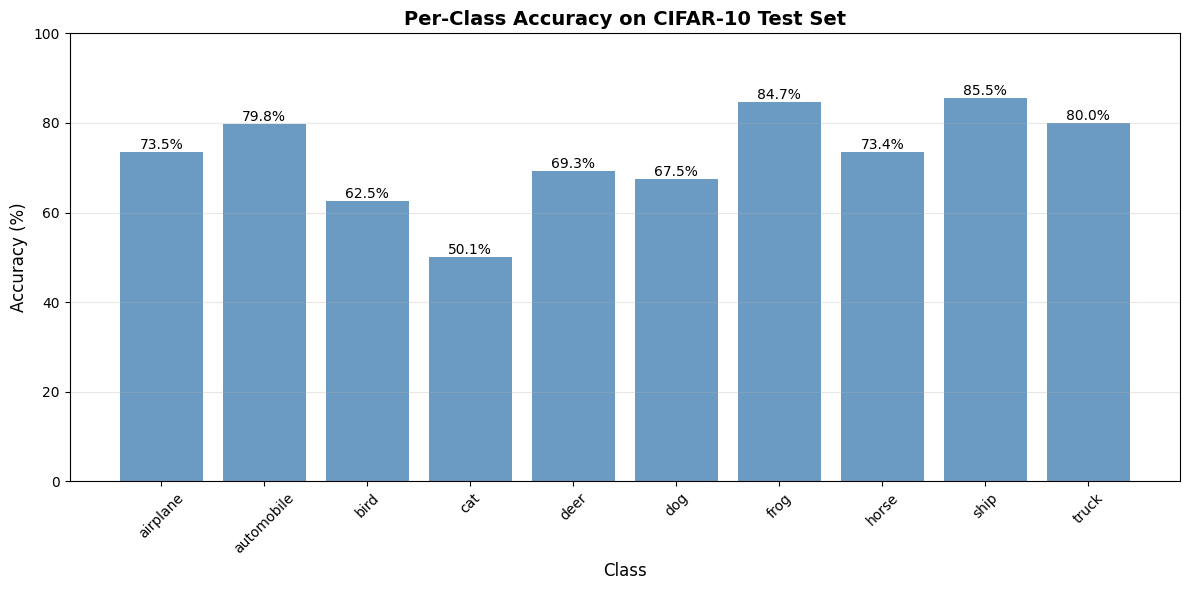

In [ ]:
# 在整个测试集上评估
class_correct = [0] * NUM_CLASSES
class_total = [0] * NUM_CLASSES

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        c = (predicted == targets)
        for i in range(len(targets)):
            label = targets[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 打印每个类别的准确率
print("各类别准确率:")
print("-" * 40)
for i in range(NUM_CLASSES):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"{classes[i]:<12}: {acc:>6.2f}% ({class_correct[i]}/{class_total[i]})")

# 绘制柱状图
class_acc = [100 * class_correct[i] / class_total[i] for i in range(NUM_CLASSES)]
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, class_acc, color='steelblue', alpha=0.8)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy on CIFAR-10 Test Set', fontsize=14, fontweight='bold')
plt.ylim([0, 100])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 在柱子上标注数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 12. 保存训练摘要

In [36]:
# 保存训练摘要
import json
from datetime import datetime

summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'embed_dim': EMBED_DIM,
        'depth': DEPTH,
        'num_heads': NUM_HEADS,
    },
    'results': {
        'best_test_acc': best_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_test_acc': history['test_acc'][-1],
    },
    'class_accuracy': {classes[i]: class_acc[i] for i in range(NUM_CLASSES)},
    'history': history
}

with open('output/training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✅ 训练摘要已保存到 training_summary.json")
print("\n训练总结:")
print("="*50)
print(f"训练轮数: {EPOCHS}")
print(f"最佳测试准确率: {best_acc:.2f}%")
print(f"最终训练准确率: {history['train_acc'][-1]:.2f}%")
print(f"最终测试准确率: {history['test_acc'][-1]:.2f}%")
print(f"模型参数量: {total_params:,}")
print("="*50)

✅ 训练摘要已保存到 training_summary.json

训练总结:
训练轮数: 10
最佳测试准确率: 72.63%
最终训练准确率: 74.83%
最终测试准确率: 72.63%
模型参数量: 4,771,082
